# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Загрузка и ресэмплирование данных

In [1]:
import pandas as pd  # Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import FunctionTransformer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])  # Откроем файл с данными
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head()  # Первые 5 строк

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.index.is_monotonic  # Проверим, в хронологическом ли порядке расположены даты и время

True

In [6]:
df = df.resample('1H').sum()  # Применим ресемплирование по часам

## Анализ данных

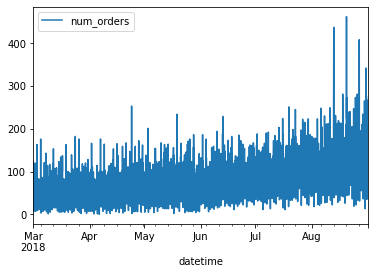

In [7]:
df.plot();  # Построим график ресемплированных данных

In [8]:
rolling_mean = df.rolling(168).mean();  # Применим скользящее среднее

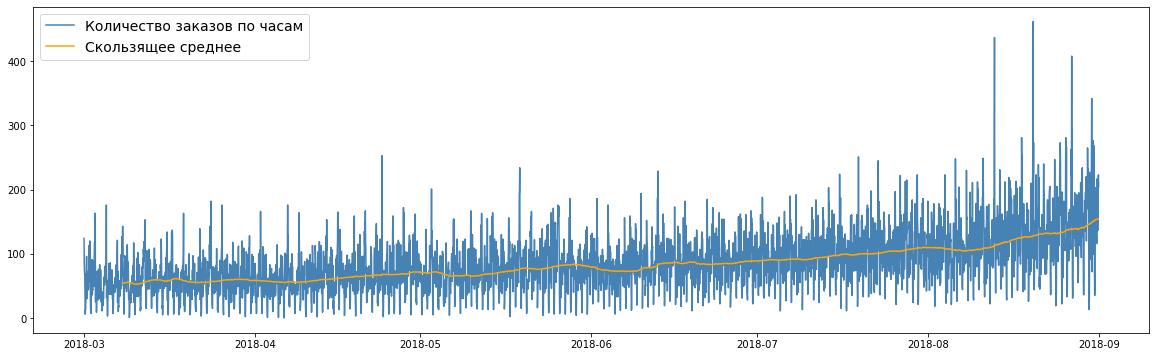

In [9]:
plt.figure(figsize=(20, 6))

plt.plot(df, label='Количество заказов по часам', color='steelblue')
plt.plot(rolling_mean, label='Скользящее среднее', color='orange')

plt.legend(fontsize=14)

plt.show()

In [10]:
decomposed = seasonal_decompose(df)  # Проведем декомпозицию данных

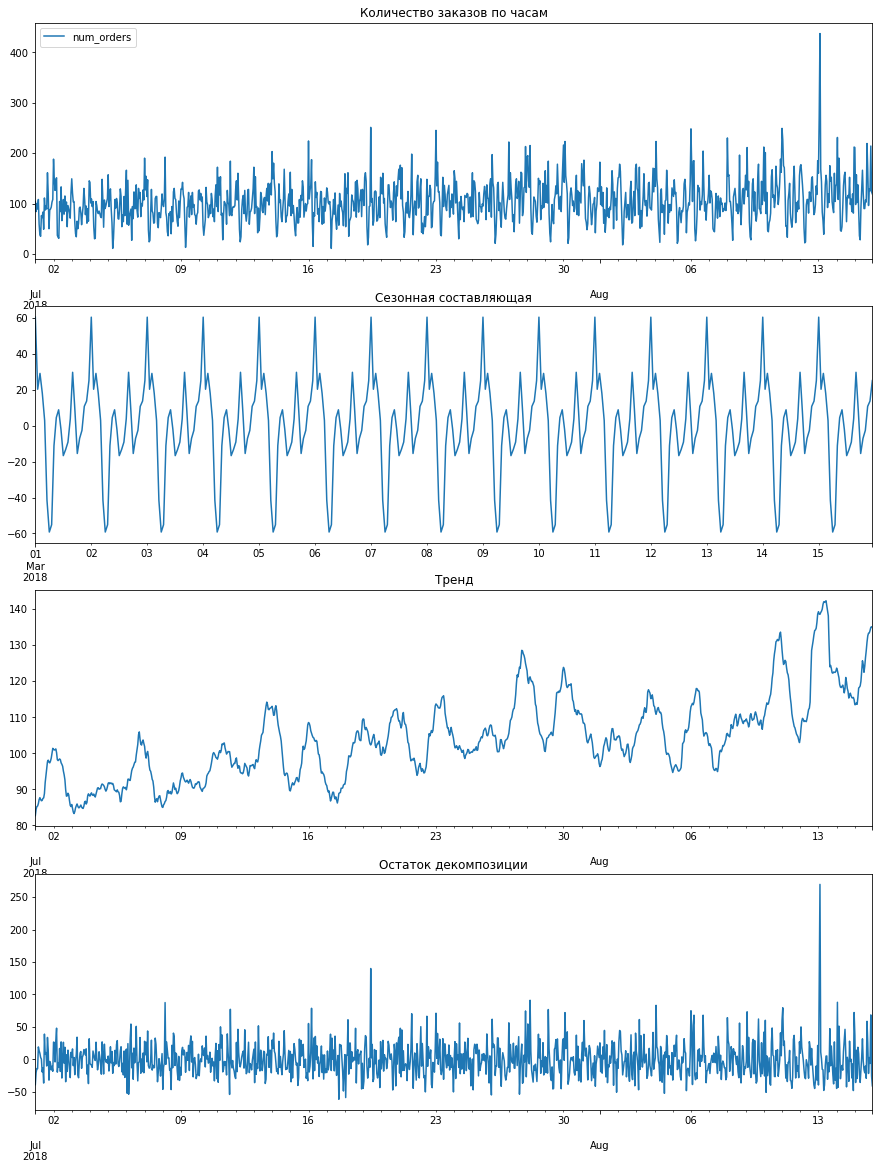

In [11]:
plt.figure(figsize=(15, 20))
plt.subplot(4,1,1)
df['2018-07-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Количество заказов по часам')
plt.xlabel('')
plt.subplot(4,1,2)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.xlabel('')
plt.subplot(4,1,3)
decomposed.trend['2018-07-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('')
plt.subplot(4,1,4)
decomposed.resid['2018-07-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.xlabel('');

In [12]:
df_day = df.resample('1D').sum()  # Применим ресемплирование по суткам

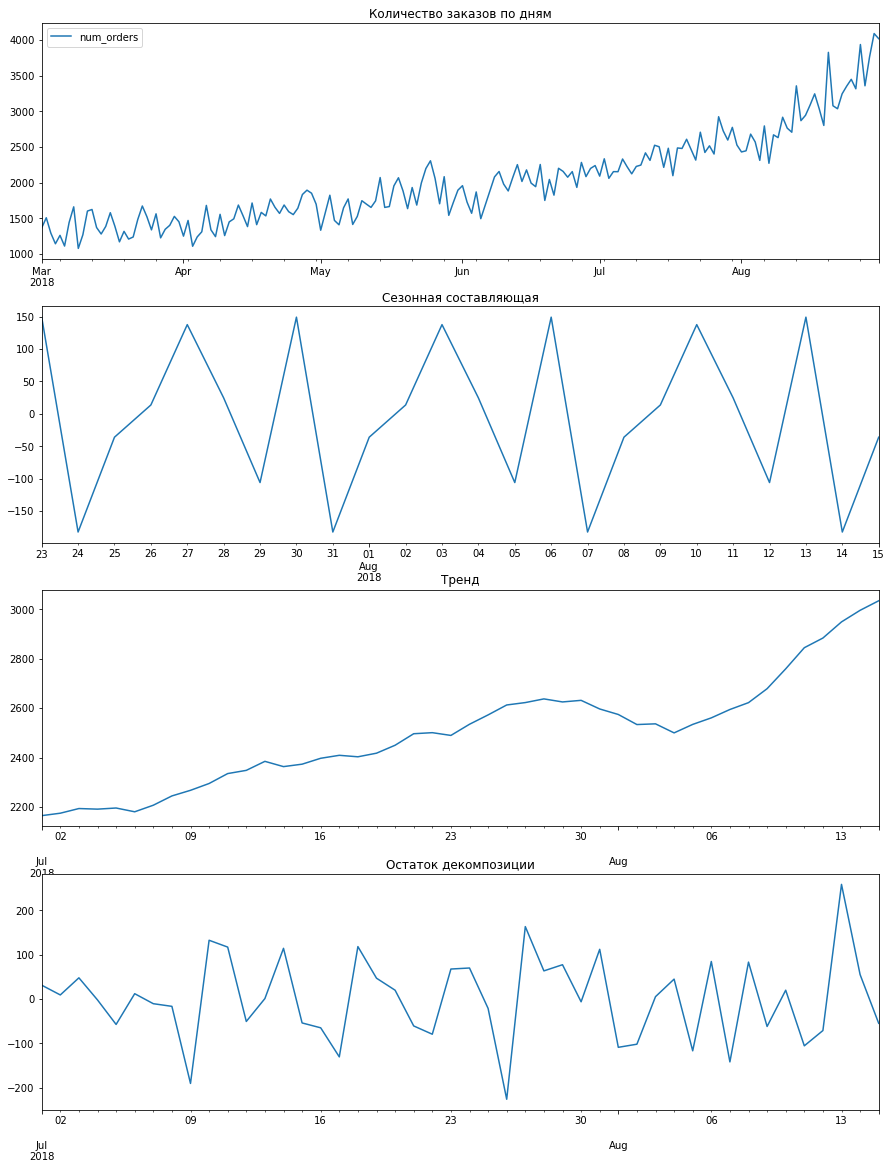

In [13]:
decomposed_day = seasonal_decompose(df_day)

plt.figure(figsize=(15, 20))
plt.subplot(4,1,1)
df_day.plot(ax=plt.gca())
plt.title('Количество заказов по дням')
plt.xlabel('')
plt.subplot(4,1,2)
decomposed_day.seasonal['2018-07-23':'2018-08-15'].plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.xlabel('')
plt.subplot(4,1,3)
decomposed_day.trend['2018-07-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('')
plt.subplot(4,1,4)
decomposed_day.resid['2018-07-01':'2018-08-15'].plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.xlabel('');

**Вывод.**
- временной ряд нестационарный, так как со временем его среднее увеличивается;
- присутствует суточная и недельная сезонность;
- виден восходящий тренд;
- в сезонной составляющей пик активности приходится на ночные часы.

## Обучение моделей

Создадим дополнительные признаки:

In [14]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

Так как мы имеем суточную и недельную сезонность, размер окна скользящего среднего(rolling_mean_size) и число отстающих значений(max_lag ) возьмем равными 168(столько часов в неделе).

In [15]:
make_features(df, 168, 168)

In [16]:
df.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Создадим на основе имеющихся признаков 'hour' и 'dayofweek' периодические признаки с помощью тригонометрических функций.

In [17]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [18]:
df['hour_sin'] = sin_transformer(24).fit_transform(df)['hour']
df['hour_cos'] = cos_transformer(24).fit_transform(df)['hour']

df['dayofweek_sin'] = sin_transformer(7).fit_transform(df)['dayofweek']
df['dayofweek_cos'] = cos_transformer(7).fit_transform(df)['dayofweek']



Разделим данные на тренировочную и тестовую выборки.

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)  
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

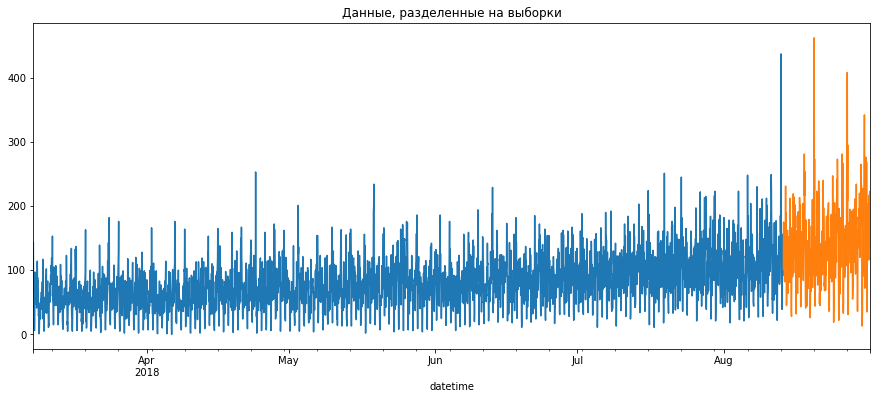

In [20]:
plt.figure(figsize=(15, 6))
plt.title('Данные, разделенные на выборки')

train['num_orders'].plot()
test['num_orders'].plot()

plt.show()

In [21]:
def rmse(y_true, y_pred):  # функция расчета метрки RMSE
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

### Линейная регрессия

In [22]:
def evaluate(model, X, y, cv):  # Функция оценки по кросс-валидации без подбора гиперпараметров
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=[ "neg_root_mean_squared_error"],
    )
   
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(

        f"RMSE на тренировочной выборке: {rmse.mean():.3f}"
    )

In [23]:
tscv = TimeSeriesSplit(n_splits=3)  
evaluate(LinearRegression(), features_train, target_train, tscv)

RMSE на тренировочной выборке: 23.123


### XGBRegressor, LGBMRegressor, CatBoostRegressor

Подберем гиперпараметры с помощью GridSearchCV, при этом, чтобы не нарушать порядок следования данных примем cv = TimeSeriesSplit(n_splits=3)

In [24]:
%%time
regressors = [XGBRegressor(), LGBMRegressor(), CatBoostRegressor()]

params = {
    'n_estimators' : [100, 200],
    'max_depth' : [5, 7],
    'random_state': [10]
}

for regressor in regressors:
    
    search = GridSearchCV(regressor, param_grid=params, refit=False, scoring=rmse_scorer, cv=tscv)

    model = search.fit(features_train, target_train)
    print(regressor)
    print("Test RMSE = %.4f" % model.best_score_)
    print( model.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Test RMSE = -25.3252
{'max_depth': 5, 'n_estimators': 100, 'random_state': 10}
LGBMRegressor()
Test RMSE = -23.7673
{'max_depth': 5, 'n_estimators': 100, 'random_state': 10}
Learning rate set to 0.264166
0:	learn: 26.7717772	total: 56.7ms	remaining: 5.61s
1:	

**Вывод.** Наилучшую метрику RMSE = 23.123 на тренировочной выборке показала модель LinearRegression. Примем эту модель за наилучшую.

## Тестирование лучшей модели

In [25]:
model = LinearRegression()  
model.fit(features_train, target_train)
pred_test = model.predict(features_test)

print('RMSE тестовой выборки: %.4f' %(rmse(target_test, pred_test)))

RMSE тестовой выборки: 34.3582


Проверим модель на адекватность. Напишем алгоритм, делающий предсказание предыдущим значением.

In [26]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE:", (mean_squared_error(test, pred_previous))**0.5)

RMSE: 55.59599845776232


## Общий вывод

В результате работы данные были ресемплированы, проанализированы. Заметен восходящий тренд; суточная и недельная сезонность; нестационарность временного ряда. Были выделены признаки 'hour' и 'dayofweek', а также сгенерированы дополнительные признаки на основе тригонометрических функций(вследствие суточной и недельной сезонности временного ряда). Затем, были обучены модели линейной регрессии и градиентного бустинга (XGBRegressor, LGBMRegressor, CatBoostRegressor). В качестве лучшей модели выбрана **модель LinearRegression, с метрикой RMSE = 34.3582 на тестовой выборке.** Модель также прошла проверку на адекватность,  показав метрику RMSE лучше, чем у алгоритма, предсказывающего предыдущее значеие.